# Analysis of Spaceship Titanic dataset

We have binary dataset of simulated data. The idea behind the data is transportation of the passangers from the planet Earth to another. Let's see how the data looks like. 

### In this iteration we apply model to generate new data for continuous columns such as Age, RoomService-VRDeck. Drop missing values from training set. Also we generate categorical variables using created models.

In [1190]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import plot_importance

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score,\
ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

import pickle

In [1191]:
df_train = pd.read_csv("train.csv")
df_train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [1192]:
df_test = pd.read_csv("test.csv")
df_test.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


In [1193]:
print(df_train.isna().sum())
df_test.isna().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64


PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64

We have around 200 observation with missing values in training dataset and 100 observations in test dataset. Since we have to upload prediction for all passengers drop missing values is not the right case and we will try to generate this values for proper analysis

In [1194]:
# df_train = df_train.dropna(axis=0)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [1195]:
df_full = pd.concat([df_train, df_test], axis=0)
df_full_intro = df_full.copy()
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12970 entries, 0 to 4276
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   12970 non-null  object 
 1   HomePlanet    12682 non-null  object 
 2   CryoSleep     12660 non-null  object 
 3   Cabin         12671 non-null  object 
 4   Destination   12696 non-null  object 
 5   Age           12700 non-null  float64
 6   VIP           12674 non-null  object 
 7   RoomService   12707 non-null  float64
 8   FoodCourt     12681 non-null  float64
 9   ShoppingMall  12664 non-null  float64
 10  Spa           12686 non-null  float64
 11  VRDeck        12702 non-null  float64
 12  Name          12676 non-null  object 
 13  Transported   8693 non-null   object 
dtypes: float64(6), object(8)
memory usage: 1.5+ MB


In [1196]:
df_full.iloc[6604:6608, :]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
6604,6971_02,Europa,False,C/225/P,TRAPPIST-1e,4.0,False,0.0,0.0,0.0,0.0,0.0,Chard Distured,True
6605,6971_03,Europa,True,C/225/P,TRAPPIST-1e,19.0,False,0.0,0.0,0.0,0.0,0.0,Alkaida Distured,True
6606,6971_04,Europa,True,C/225/P,55 Cancri e,17.0,False,0.0,0.0,0.0,0.0,0.0,Asteron Distured,True
6607,6971_05,Europa,False,C/225/P,55 Cancri e,28.0,False,0.0,4173.0,0.0,33.0,420.0,Schird Pretive,True


### We start from analysis of each column and replace missing values

#### Since we will not consider Passenger ID for model simulation which could introduce bias, first column will be Home Planet

In [1197]:
df_full["HomePlanet"].value_counts()

Earth     6865
Europa    3133
Mars      2684
Name: HomePlanet, dtype: int64

In [1198]:
df_full["HomePlanet"].isna()

0       False
1       False
2       False
3       False
4       False
        ...  
4272    False
4273    False
4274    False
4275    False
4276    False
Name: HomePlanet, Length: 12970, dtype: bool

I lean towards replacements all values with Earth, since majority of the passengers ~60% is from Earth, so on avarage we will be right in 60 % observations. So for 170 observation we have a good data and rest 100 will not have large impact on data compare to 12K observations

In [1199]:
df_full.loc[df_full["HomePlanet"].isna(), "HomePlanet"] = "Earth"
df_full["HomePlanet"].value_counts()

Earth     7153
Europa    3133
Mars      2684
Name: HomePlanet, dtype: int64

### For the second column we examine CryoSleep as False and True value and later convert it to 1 and 0 values

In [1200]:
df_full["CryoSleep"].value_counts()

False    8079
True     4581
Name: CryoSleep, dtype: int64

In [1201]:
df_full["CryoSleep"].isna().sum()

310

In this case we replace missing data with False as for 65% of the data it will be right approach and for rest 140 missrepresented value will not probably have large imapact 

In [1202]:
df_full.loc[df_full["CryoSleep"].isna(), "CryoSleep"] = False
df_full["CryoSleep"] = df_full["CryoSleep"].astype(int)
df_full["CryoSleep"].value_counts()

0    8389
1    4581
Name: CryoSleep, dtype: int64

### Column Cabin as itself does not provide much of the information, so we separate this into columns Deck and Side. 

Number of the room is not well understood since have many 0's and 1's which can be misrepresented by model. So we create new columns and drop Cabin. Later we examine each of newly created 

In [1203]:
def find_value(row, num):
        try:
            return str(row).split("/")[num]
        except IndexError:
            return None
    
df_full_intro["Deck"] = df_full["Cabin"].apply(lambda x: str(x).split("/")[0] if x else None)
df_full_intro["Side"] = df_full["Cabin"].apply(lambda x: find_value(x, 2))  
df_full_intro.iloc[df_full_intro["Deck"]=="nan"]=None
df_full_intro["Deck"].isna().sum()

299

In [1204]:
df_full.loc[df_full["Cabin"].isna(), "Cabin"] = "F/JD/S"

In [1205]:
df_full["Deck"] = df_full["Cabin"].apply(lambda x: str(x).split("/")[0])
df_full["Deck"].value_counts()

F    4538
G    3781
E    1323
B    1141
C    1102
D     720
A     354
T      11
Name: Deck, dtype: int64

In [1206]:
df_full["Side"] = df_full["Cabin"].apply(lambda x: find_value(x, 2))  
df_full["Side"].value_counts()

S    6680
P    6290
Name: Side, dtype: int64

In [1207]:
df_full["Side"].isna().sum()

0

I replaced Deck with F value and Side with S as most common and for majority will be correct. Another approach would be just drop values in training set and replace values in test.

In [1208]:
df_full = df_full.drop(columns="Cabin", axis=1)
df_full.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Deck,Side
0,0001_01,Europa,0,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,B,P
1,0002_01,Earth,0,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,F,S
2,0003_01,Europa,0,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,A,S
3,0003_02,Europa,0,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,A,S
4,0004_01,Earth,0,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,F,S


#### Next column will be Destination. 

In [1209]:
df_full["Destination"].value_counts()

TRAPPIST-1e      8871
55 Cancri e      2641
PSO J318.5-22    1184
Name: Destination, dtype: int64

In [1210]:
df_full["Destination"].isna().sum()

274

We have majority who is moving to the planet Trappist and 70% we have a good chance for replacing missing values for this planet. Later we will use dummy variables to trasform this column. 

In [1211]:
df_full.loc[df_full["Destination"].isna(), "Destination"] = "TRAPPIST-1e"
df_full["Destination"].value_counts()

TRAPPIST-1e      9145
55 Cancri e      2641
PSO J318.5-22    1184
Name: Destination, dtype: int64

In [1212]:
df_full["Destination"] = df_full["Destination"].replace("TRAPPIST-1e", "TRAPPIST").replace("55 Cancri e", "Cancri").replace("PSO J318.5-22", "PSO")
df_full["Destination"].value_counts()

TRAPPIST    9145
Cancri      2641
PSO         1184
Name: Destination, dtype: int64

#### Next column age. For this case we use avarage age for the population.

In [1213]:
df_full["Age"].describe()

count    12700.000000
mean        28.771969
std         14.387261
min          0.000000
25%         19.000000
50%         27.000000
75%         38.000000
max         79.000000
Name: Age, dtype: float64

In [1214]:
df_full["Age"].isna().sum()

270

In [1215]:
df_full.loc[df_full["Age"].isna(), "Age"] = 28
df_full.describe()

,CryoSleep,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,12970.000000,12970.000000,12707.000000,12681.000000,12664.000000,12686.000000,12702.000000
mean,0.353200,28.755898,222.897852,451.961675,174.906033,308.476904,306.789482
std,0.477983,14.237137,647.596664,1584.370747,590.558690,1130.279641,1180.097223
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,37.000000,49.000000,77.000000,29.000000,57.000000,42.000000
max,1.000000,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


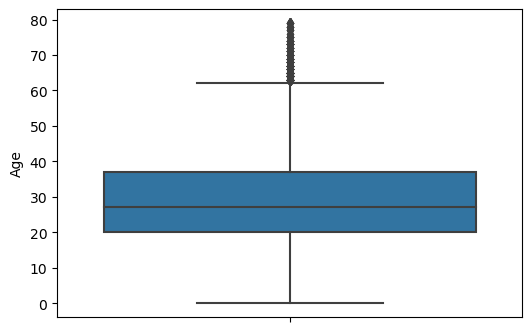

In [1216]:
plt.figure(figsize=(6, 4))  
sns.boxplot(y = df_full["Age"])

plt.ylabel("Age")  

plt.show()

In [1217]:
percentile25 = df_full["Age"].quantile(0.25)
percentile75 = df_full["Age"].quantile(0.75)

iqr = percentile75 - percentile25

upper_limit = percentile75 + 1.5 * iqr
lower_limit = percentile25 - 1.5 * iqr
print("Upper limit", upper_limit)
print("Lower limit", lower_limit)

outlier_age = df_full[(df_full["Age"] > upper_limit) | (df_full["Age"] < lower_limit)]

print("Number of outliers in the Age section", len(outlier_age))
print(1.5 * iqr)

Upper limit 62.5
Lower limit -5.5
Number of outliers in the Age section 237
25.5


We replaced missing values from dataset by average age of the population. Also notible that Age has outliers (237) which could affect some models like Logistic Regression and Naive Bayes. For Random Forest it will affect only in extreme cases, so we stick with this and correct in case of nessacity.

### Next we explore VIP

In [1218]:
df_full["VIP"].value_counts()

False    12401
True       273
Name: VIP, dtype: int64

In [1219]:
df_full["VIP"].isna().sum()

296

In [1220]:
df_full.loc[df_full["VIP"].isna(), "VIP"] = False
df_full["VIP"] = df_full["VIP"].astype(int)
df_full["VIP"].value_counts()

0    12697
1      273
Name: VIP, dtype: int64

In [1221]:
df_full.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Deck,Side
0,0001_01,Europa,0,TRAPPIST,39.0,0,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,B,P
1,0002_01,Earth,0,TRAPPIST,24.0,0,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,F,S
2,0003_01,Europa,0,TRAPPIST,58.0,1,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,A,S
3,0003_02,Europa,0,TRAPPIST,33.0,0,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,A,S
4,0004_01,Earth,0,TRAPPIST,16.0,0,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,F,S


### Room Service, Food Court, Shopping Mall, Spa, VR Deck

All these columns have consecutive values and we replace missing values with median value in each column

In [1222]:
df_full["RoomService"].describe()

count    12707.000000
mean       222.897852
std        647.596664
min          0.000000
25%          0.000000
50%          0.000000
75%         49.000000
max      14327.000000
Name: RoomService, dtype: float64

In [1223]:
df_full["RoomService"].isna().sum()

263

In [1224]:
df_full["RoomService"].median()

0.0

In [1225]:
df_full.loc[df_full["RoomService"].isna(), "RoomService"] = 0.0
df_full["RoomService"].isna().sum()

0

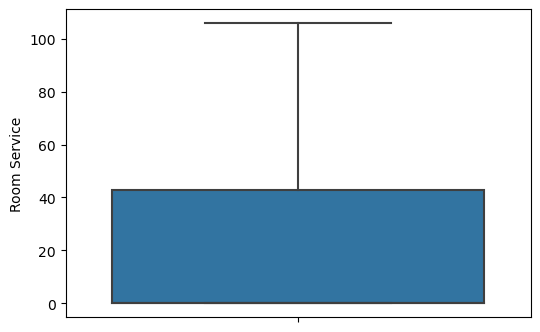

In [1226]:
plt.figure(figsize=(6, 4))  
sns.boxplot(y = df_full["RoomService"], showfliers=False)

plt.ylabel("Room Service")  

plt.show()

As we can see majority of the values are outliers and most probably it is introduce large bias

In [1227]:
df_full["FoodCourt"].describe()

count    12681.000000
mean       451.961675
std       1584.370747
min          0.000000
25%          0.000000
50%          0.000000
75%         77.000000
max      29813.000000
Name: FoodCourt, dtype: float64

In [1228]:
df_full["FoodCourt"].isna().sum()

289

In [1229]:
df_full["FoodCourt"].median()

0.0

In [1230]:
df_full.loc[df_full["FoodCourt"].isna(), "FoodCourt"] = 0.0

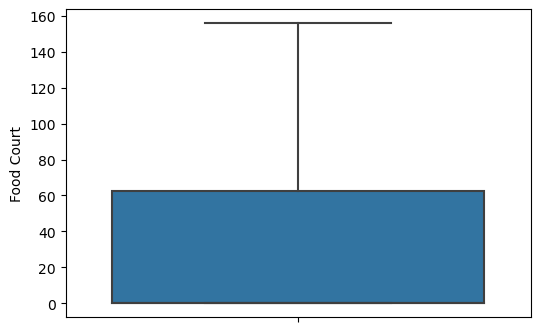

In [1231]:
plt.figure(figsize=(6, 4))  
sns.boxplot(y = df_full["FoodCourt"], showfliers=False)

plt.ylabel("Food Court")  

plt.show()

Similar case for Food Court

In [1232]:
df_full["ShoppingMall"].describe()

count    12664.000000
mean       174.906033
std        590.558690
min          0.000000
25%          0.000000
50%          0.000000
75%         29.000000
max      23492.000000
Name: ShoppingMall, dtype: float64

In [1233]:
df_full["ShoppingMall"].isna().sum()

306

In [1234]:
df_full.loc[df_full["ShoppingMall"].isna(), "ShoppingMall"] = 0.0
df_full["ShoppingMall"].isna().sum()

0

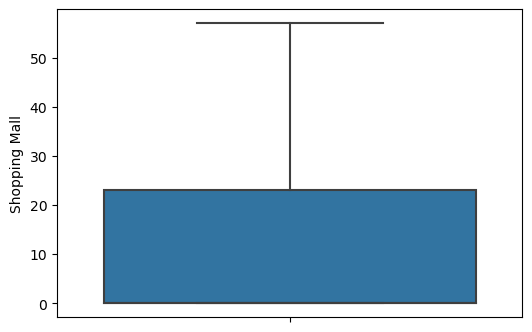

In [1235]:
plt.figure(figsize=(6, 4))  
sns.boxplot(y = df_full["ShoppingMall"], showfliers=False)

plt.ylabel("Shopping Mall")  

plt.show()

In [1236]:
df_full["Spa"].describe()

count    12686.000000
mean       308.476904
std       1130.279641
min          0.000000
25%          0.000000
50%          0.000000
75%         57.000000
max      22408.000000
Name: Spa, dtype: float64

In [1237]:
df_full["Spa"].isna().sum()

284

In [1238]:
df_full.loc[df_full["Spa"].isna(), "Spa"] = 0.0
df_full["Spa"].isna().sum()

0

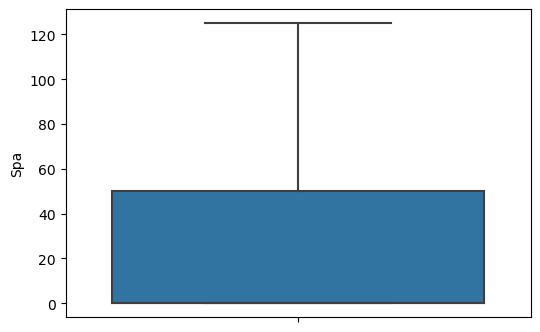

In [1239]:
plt.figure(figsize=(6, 4))  
sns.boxplot(y = df_full["Spa"], showfliers=False)

plt.ylabel("Spa")  

plt.show()

In [1240]:
df_full["VRDeck"].describe()

count    12702.000000
mean       306.789482
std       1180.097223
min          0.000000
25%          0.000000
50%          0.000000
75%         42.000000
max      24133.000000
Name: VRDeck, dtype: float64

In [1241]:
df_full.loc[df_full["VRDeck"].isna(), "VRDeck"] = 0.0
df_full["VRDeck"].isna().sum()

0

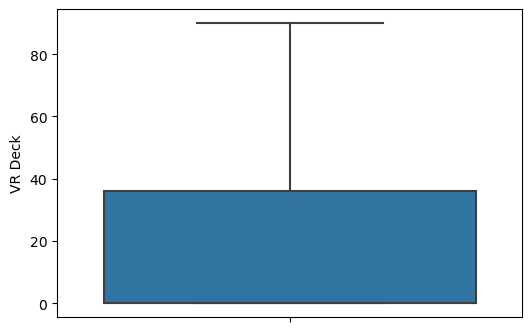

In [1242]:
plt.figure(figsize=(6, 4))  
sns.boxplot(y = df_full["VRDeck"], showfliers=False)

plt.ylabel("VR Deck")  

plt.show()

As we can see every of this column has extensive outliers which can affect our model prediction. We can make one column as TotalSpend

In [1243]:
df_full["TotalSpend"] = (
    df_full["RoomService"] + 
    df_full["FoodCourt"] + 
    df_full["ShoppingMall"] + 
    df_full["Spa"] + 
    df_full["VRDeck"]
)
df_full["TotalSpend"].describe()

count    12970.000000
mean      1433.221049
std       2807.369708
min          0.000000
25%          0.000000
50%        716.000000
75%       1442.000000
max      35987.000000
Name: TotalSpend, dtype: float64

In [1244]:
df_full["TotalSpend"].isna().sum()

0

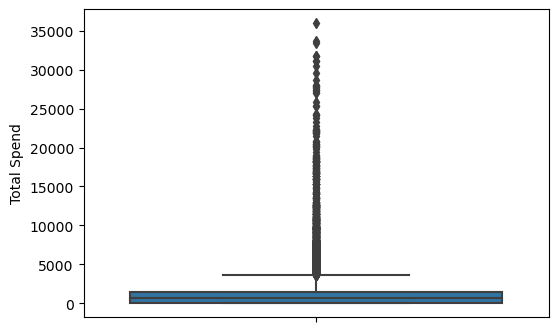

In [1245]:
plt.figure(figsize=(6, 4))  
sns.boxplot(y = df_full["TotalSpend"], showfliers=True)

plt.ylabel("Total Spend")  

plt.show()

In [1246]:
zeros_TotalSpend = df_full[df_full["TotalSpend"] == 0.0]
print("Number of obs that have 0 spend", len(zeros_TotalSpend))

Number of obs that have 0 spend 5457


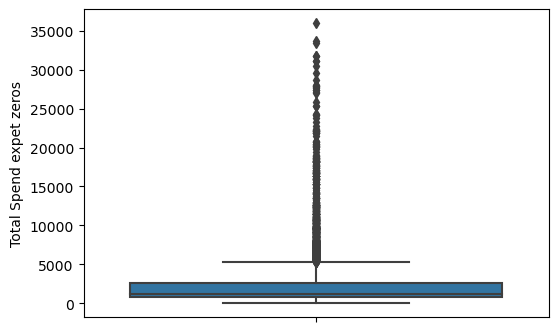

In [1247]:
not_zeros = df_full[df_full["TotalSpend"] > 0]
plt.figure(figsize=(6, 4))  
sns.boxplot(y = not_zeros["TotalSpend"], showfliers=True)

plt.ylabel("Total Spend expet zeros")  

plt.show()

##### I have decided to create new column Rich as to describe outliers in this data and rest of the column just drop.

In [1248]:
percentile25 = df_full["TotalSpend"].quantile(0.25)
percentile75 = df_full["TotalSpend"].quantile(0.75)

iqr = percentile75 - percentile25

upper_limit = percentile75 + 1.5 * iqr
lower_limit = percentile25 - 1.5 * iqr
print("Upper limit", upper_limit)
print("Lower limit", lower_limit)

outlier_total_spend = df_full[(df_full["TotalSpend"] > upper_limit) | (df_full["TotalSpend"] < lower_limit)]

print("Number of outliers in the TotalSpend section", len(outlier_total_spend))

Upper limit 3605.0
Lower limit -2163.0
Number of outliers in the TotalSpend section 1357


We will identify Rich people as someone who spend more 3668 over the trip on accomodation.

In [1249]:
df_full["Rich"] = df_full["TotalSpend"].apply(lambda x: True if x >= 3605 else False)
df_full["Rich"] = df_full["Rich"].astype(int)
df_full.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Deck,Side,TotalSpend,Rich
0,0001_01,Europa,0,TRAPPIST,39.0,0,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,B,P,0.0,0
1,0002_01,Earth,0,TRAPPIST,24.0,0,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,F,S,736.0,0
2,0003_01,Europa,0,TRAPPIST,58.0,1,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,A,S,10383.0,1
3,0003_02,Europa,0,TRAPPIST,33.0,0,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,A,S,5176.0,1
4,0004_01,Earth,0,TRAPPIST,16.0,0,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,F,S,1091.0,0


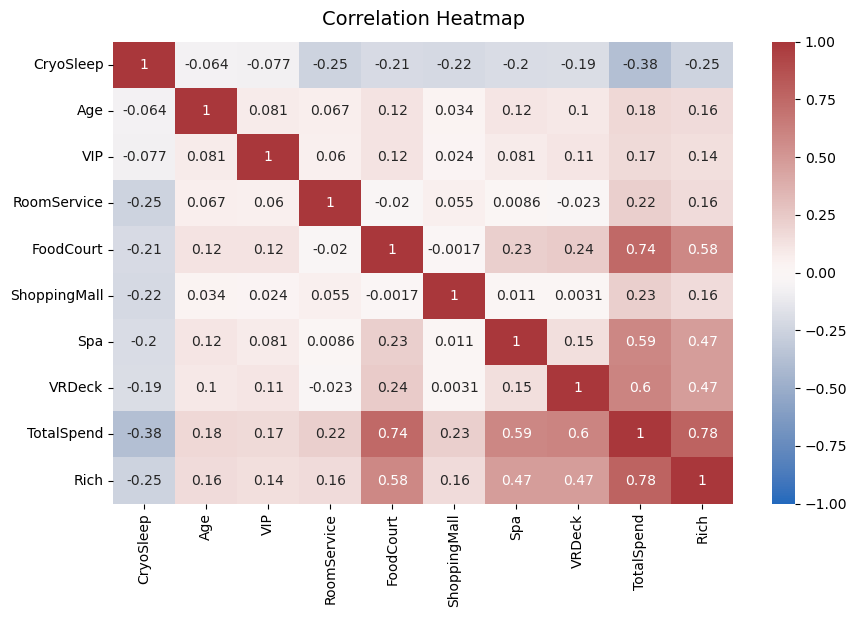

In [1250]:
plt.figure(figsize=(10, 6))
heatmap = sns.heatmap(df_full.corr(), vmin=-1, vmax=1, annot=True, cmap=sns.color_palette("vlag", as_cmap=True))
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':14}, pad=12);

#### Now we do not have strong correlation between variables which we expect would help with the model

### Only categorical data left, so we apply dummy encoding to columns Home planet, Destination, Deck and Side

In [1251]:
df_full_enc = pd.get_dummies(df_full, columns=["HomePlanet", "Destination", "Deck", "Side"], drop_first=False)
df_full_enc.head()

,PassengerId,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,...,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_P,Side_S
0,0001_01,0,39.0,0,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,...,0,1,0,0,0,0,0,0,1,0
1,0002_01,0,24.0,0,109.0,9.0,25.0,549.0,44.0,Juanna Vines,...,0,0,0,0,0,1,0,0,0,1
2,0003_01,0,58.0,1,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,...,1,0,0,0,0,0,0,0,0,1
3,0003_02,0,33.0,0,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,...,1,0,0,0,0,0,0,0,0,1
4,0004_01,0,16.0,0,303.0,70.0,151.0,565.0,2.0,Willy Santantines,...,0,0,0,0,0,1,0,0,0,1


In [1252]:
df_full_enc = df_full_enc.drop(columns=["PassengerId", "Name", "Transported", "Rich", "TotalSpend"], axis=1)
df_full.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Deck,Side,TotalSpend,Rich
0,0001_01,Europa,0,TRAPPIST,39.0,0,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,B,P,0.0,0
1,0002_01,Earth,0,TRAPPIST,24.0,0,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,F,S,736.0,0
2,0003_01,Europa,0,TRAPPIST,58.0,1,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,A,S,10383.0,1
3,0003_02,Europa,0,TRAPPIST,33.0,0,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,A,S,5176.0,1
4,0004_01,Earth,0,TRAPPIST,16.0,0,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,F,S,1091.0,0


Six columns has consecutive values with outstanding outliers which we can eliminate by scaling. Now we apply Standart Scaler to reduce bias in the data

In [1253]:
columns_to_scale = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

# Create an instance of StandardScaler
scaler = StandardScaler()

# Fit the scaler to the selected columns
scaler.fit(df_full_enc[columns_to_scale])

# Transform the selected columns
scaled_columns = scaler.transform(df_full_enc[columns_to_scale])

# Create a copy of the original data and replace the scaled columns with the scaled values
df_full_enc[columns_to_scale] = scaled_columns
df_full_enc.head()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet_Earth,HomePlanet_Europa,...,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_P,Side_S
0,0,0.719562,0,-0.340290,-0.281822,-0.292365,-0.269707,-0.257100,0,1,...,0,1,0,0,0,0,0,0,1,0
1,0,-0.334062,0,-0.170439,-0.276082,-0.249566,0.221040,-0.219449,1,0,...,0,0,0,0,0,1,0,0,0,1
2,0,2.054151,1,-0.273285,1.998823,-0.292365,5.732776,-0.215170,0,1,...,1,0,0,0,0,0,0,0,0,1
3,0,0.298112,0,-0.340290,0.536429,0.342766,2.706059,-0.091947,0,1,...,1,0,0,0,0,0,0,0,0,1
4,0,-0.895994,0,0.131863,-0.237179,-0.033861,0.235342,-0.255389,1,0,...,0,0,0,0,0,1,0,0,0,1


## Now we are going to generate new data by using the created model and create new dataset

In [1254]:
df_full_intro["Age"].isna().sum()

564

In [1255]:
df_age = df_full_enc[df_full_intro["Age"].isna()].drop(columns=["Age"], axis=1)
df_age.head()

,CryoSleep,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,...,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_P,Side_S
15,0,0,-0.290425,-0.281822,1.207298,-0.269707,-0.257100,1,0,0,...,0,0,0,0,0,1,0,0,0,1
50,0,0,-0.334057,-0.281822,-0.288941,3.916388,-0.257100,1,0,0,...,0,0,0,0,0,0,1,0,0,1
64,0,0,0.895410,-0.281822,-0.288941,-0.043552,-0.257100,0,0,1,...,0,0,0,0,1,0,0,0,0,1
93,1,0,-0.340290,-0.281822,-0.292365,-0.269707,-0.257100,0,0,1,...,0,0,0,0,0,1,0,0,0,1
103,0,0,-0.340290,-0.020339,-0.282093,3.242394,0.396667,0,1,0,...,0,0,0,0,0,1,0,0,0,1


In [1256]:
def read_pickle(path, saved_model_name:str):
    '''
    saved_model_name is a string.
    '''
    with open(path + saved_model_name + '.pickle', 'rb') as to_read:
        model = pickle.load(to_read)

        return model

In [1257]:
rf_cv1 = read_pickle("", "model_age")

In [1258]:
age_pred = rf_cv1.predict(df_age)
print(age_pred)

[ 0.04533202  0.0139545   0.15272114  0.10540178  0.31837557 -0.092268
  0.47308317  0.32958608  0.06886313  0.10540178  0.51144056 -0.1087095
  0.41177033  0.01923882  0.32243119 -0.14846496  0.05620678  0.24000137
  0.01923882 -0.02369884  0.41177033  0.54944017  0.41177033  0.13071949
  0.01923882  0.41177033  0.21499333  0.00331861  0.00554381  0.01923882
  0.10172273 -0.14846496  0.34035545  0.51144056 -0.05608173  0.481375
 -0.08666016  0.41177033  0.41177033  0.25523844  0.09903274  0.41177033
  0.09519453  0.58318372  0.12246892  0.09010271  0.1566703   0.41177033
  0.04088747  0.18970088 -0.02332596  0.39732181  0.10540178 -0.02412761
  0.27865873 -0.04399191 -0.0639066  -0.02490016  0.38373358  0.10540178
  0.38373358 -0.0224336   0.17212578  0.01923882  0.41177033  0.46250479
  0.48688768  0.15705128  0.10540178  0.10540178 -0.00139387  0.41177033
  0.4387922   0.42455057  0.28249021 -0.04399191  0.38373358  0.00554381
  0.1889823   0.31728479  0.11675118  0.10540178  0.0254

In [1259]:
df_full_enc.loc[df_full_intro["Age"].isna(), "Age"] = age_pred
df_full_enc[df_full_intro["Age"].isna()]

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet_Earth,HomePlanet_Europa,...,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_P,Side_S
15,0,0.045332,0,-0.290425,-0.281822,1.207298,-0.269707,-0.257100,1,0,...,0,0,0,0,0,1,0,0,0,1
50,0,0.013955,0,-0.334057,-0.281822,-0.288941,3.916388,-0.257100,1,0,...,0,0,0,0,0,0,1,0,0,1
64,0,0.152721,0,0.895410,-0.281822,-0.288941,-0.043552,-0.257100,0,0,...,0,0,0,0,1,0,0,0,0,1
93,1,0.105402,0,-0.340290,-0.281822,-0.292365,-0.269707,-0.257100,0,0,...,0,0,0,0,0,1,0,0,0,1
103,0,0.318376,0,-0.340290,-0.020339,-0.282093,3.242394,0.396667,0,1,...,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4249,1,0.105402,0,-0.340290,-0.281822,-0.292365,-0.269707,-0.257100,0,0,...,0,0,0,0,0,1,0,0,0,1
4258,1,0.019239,0,-0.340290,-0.281822,-0.292365,-0.269707,-0.257100,1,0,...,0,0,0,0,0,1,0,0,0,1
4273,0,0.036989,0,-0.340290,0.258364,-0.263262,-0.260768,-0.133877,1,0,...,0,0,0,0,0,1,0,0,0,1
4274,1,0.225708,0,-0.340290,-0.281822,-0.292365,-0.269707,-0.257100,0,0,...,0,0,0,1,0,0,0,0,1,0


In [1260]:
df_full_intro["RoomService"].isna().sum()

558

In [1261]:
df_rs = df_full_enc[df_full_intro["RoomService"].isna()].drop(columns=["RoomService"], axis=1)
df_rs.head()

,CryoSleep,Age,VIP,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,...,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_P,Side_S
15,0,0.045332,0,-0.281822,1.207298,-0.269707,-0.2571,1,0,0,...,0,0,0,0,0,1,0,0,0,1
25,1,-1.949617,0,-0.281822,-0.292365,-0.269707,-0.2571,1,0,0,...,0,0,0,0,1,0,0,0,0,1
35,0,-0.615028,0,-0.281822,2.703538,0.615246,-0.2571,0,0,1,...,0,0,0,0,0,1,0,0,1,0
83,1,-0.193579,0,-0.281822,-0.292365,-0.269707,-0.2571,1,0,0,...,0,0,0,0,0,0,1,0,0,1
93,1,0.105402,0,-0.281822,-0.292365,-0.269707,-0.2571,0,0,1,...,0,0,0,0,0,1,0,0,0,1


In [1262]:
rf_cv2 = read_pickle("", "model_room_service")

In [1263]:
rs_pred = rf_cv2.predict(df_rs)
df_full_enc.loc[df_full_intro["RoomService"].isna(), "RoomService"] = rs_pred
df_full_enc[df_full_intro["RoomService"].isna()].head()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet_Earth,HomePlanet_Europa,...,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_P,Side_S
15,0,0.045332,0,-0.159082,-0.281822,1.207298,-0.269707,-0.2571,1,0,...,0,0,0,0,0,1,0,0,0,1
25,1,-1.949617,0,-0.213432,-0.281822,-0.292365,-0.269707,-0.2571,1,0,...,0,0,0,0,1,0,0,0,0,1
35,0,-0.615028,0,0.810547,-0.281822,2.703538,0.615246,-0.2571,0,0,...,0,0,0,0,0,1,0,0,1,0
83,1,-0.193579,0,-0.248242,-0.281822,-0.292365,-0.269707,-0.2571,1,0,...,0,0,0,0,0,0,1,0,0,1
93,1,0.105402,0,-0.298808,-0.281822,-0.292365,-0.269707,-0.2571,0,0,...,0,0,0,0,0,1,0,0,0,1


In [1264]:
df_full_enc.head()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet_Earth,HomePlanet_Europa,...,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_P,Side_S
0,0,0.719562,0,-0.340290,-0.281822,-0.292365,-0.269707,-0.257100,0,1,...,0,1,0,0,0,0,0,0,1,0
1,0,-0.334062,0,-0.170439,-0.276082,-0.249566,0.221040,-0.219449,1,0,...,0,0,0,0,0,1,0,0,0,1
2,0,2.054151,1,-0.273285,1.998823,-0.292365,5.732776,-0.215170,0,1,...,1,0,0,0,0,0,0,0,0,1
3,0,0.298112,0,-0.340290,0.536429,0.342766,2.706059,-0.091947,0,1,...,1,0,0,0,0,0,0,0,0,1
4,0,-0.895994,0,0.131863,-0.237179,-0.033861,0.235342,-0.255389,1,0,...,0,0,0,0,0,1,0,0,0,1


In [1265]:
df_full_intro["FoodCourt"].isna().sum()

580

In [1266]:
df_fc = df_full_enc[df_full_intro["FoodCourt"].isna()].drop(columns=["FoodCourt"], axis=1)
df_fc.head()

,CryoSleep,Age,VIP,RoomService,ShoppingMall,Spa,VRDeck,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,...,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_P,Side_S
15,0,0.045332,0,-0.159082,1.207298,-0.269707,-0.257100,1,0,0,...,0,0,0,0,0,1,0,0,0,1
93,1,0.105402,0,-0.298808,-0.292365,-0.269707,-0.257100,0,0,1,...,0,0,0,0,0,1,0,0,0,1
95,0,-0.334062,0,-0.340290,-0.292365,-0.269707,-0.242553,1,0,0,...,0,0,0,0,0,1,0,0,0,1
103,0,0.318376,0,-0.207462,-0.282093,3.242394,0.396667,0,1,0,...,0,0,0,0,0,1,0,0,0,1
218,1,-0.123337,0,-0.340290,-0.292365,-0.269707,-0.257100,1,0,0,...,0,0,0,0,0,0,1,0,0,1


In [1267]:
rf_cv3 = read_pickle("", "model_food_court")

In [1268]:
fc_pred = rf_cv3.predict(df_fc)
df_full_enc.loc[df_full_intro["FoodCourt"].isna(), "FoodCourt"] = fc_pred
df_full_enc[df_full_intro["FoodCourt"].isna()].head()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet_Earth,HomePlanet_Europa,...,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_P,Side_S
15,0,0.045332,0,-0.159082,-0.186832,1.207298,-0.269707,-0.257100,1,0,...,0,0,0,0,0,1,0,0,0,1
93,1,0.105402,0,-0.298808,-0.180047,-0.292365,-0.269707,-0.257100,0,0,...,0,0,0,0,0,1,0,0,0,1
95,0,-0.334062,0,-0.340290,0.175628,-0.292365,-0.269707,-0.242553,1,0,...,0,0,0,0,0,1,0,0,0,1
103,0,0.318376,0,-0.207462,0.987747,-0.282093,3.242394,0.396667,0,1,...,0,0,0,0,0,1,0,0,0,1
218,1,-0.123337,0,-0.340290,-0.165975,-0.292365,-0.269707,-0.257100,1,0,...,0,0,0,0,0,0,1,0,0,1


In [1269]:
df_full_intro["ShoppingMall"].isna().sum()

600

In [1270]:
df_sm = df_full_enc[df_full_intro["ShoppingMall"].isna()].drop(columns=["ShoppingMall"], axis=1)
df_sm.head()

,CryoSleep,Age,VIP,RoomService,FoodCourt,Spa,VRDeck,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,...,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_P,Side_S
10,1,0.368354,0,-0.340290,-0.281822,-0.269707,-0.2571,0,1,0,...,0,1,0,0,0,0,0,0,1,0
15,0,0.045332,0,-0.159082,-0.186832,-0.269707,-0.2571,1,0,0,...,0,0,0,0,0,1,0,0,0,1
16,0,-0.123337,0,1.663633,-0.204015,-0.269707,-0.2571,0,0,1,...,0,0,0,0,0,1,0,0,1,0
23,1,0.017146,0,-0.340290,-0.281822,-0.269707,-0.2571,1,0,0,...,0,0,0,0,1,0,0,0,0,1
28,1,2.335117,0,-0.340290,-0.281822,-0.269707,-0.2571,0,1,0,...,0,0,1,0,0,0,0,0,0,1


In [1271]:
rf_cv4 = read_pickle("", "model_shopping_mall")

In [1272]:
sm_pred = rf_cv4.predict(df_sm)
df_full_enc.loc[df_full_intro["ShoppingMall"].isna(), "ShoppingMall"] = sm_pred
df_full_enc[df_full_intro["ShoppingMall"].isna()].head()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet_Earth,HomePlanet_Europa,...,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_P,Side_S
10,1,0.368354,0,-0.340290,-0.281822,0.050658,-0.269707,-0.2571,0,1,...,0,1,0,0,0,0,0,0,1,0
15,0,0.045332,0,-0.159082,-0.186832,0.396132,-0.269707,-0.2571,1,0,...,0,0,0,0,0,1,0,0,0,1
16,0,-0.123337,0,1.663633,-0.204015,0.344562,-0.269707,-0.2571,0,0,...,0,0,0,0,0,1,0,0,1,0
23,1,0.017146,0,-0.340290,-0.281822,-0.069199,-0.269707,-0.2571,1,0,...,0,0,0,0,1,0,0,0,0,1
28,1,2.335117,0,-0.340290,-0.281822,0.115631,-0.269707,-0.2571,0,1,...,0,0,1,0,0,0,0,0,0,1


In [1273]:
df_full_intro["Spa"].isna().sum()

580

In [1274]:
df_sp = df_full_enc[df_full_intro["Spa"].isna()].drop(columns=["Spa"], axis=1)
df_sp.head()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,VRDeck,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,...,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_P,Side_S
15,0,0.045332,0,-0.159082,-0.186832,0.396132,-0.257100,1,0,0,...,0,0,0,0,0,1,0,0,0,1
48,0,0.438595,0,0.890736,-0.281822,-0.292365,-0.257100,1,0,0,...,0,0,0,0,1,0,0,0,0,1
93,1,0.105402,0,-0.298808,-0.180047,0.495850,-0.257100,0,0,1,...,0,0,0,0,0,1,0,0,0,1
103,0,0.318376,0,-0.207462,0.987747,0.001139,0.396667,0,1,0,...,0,0,0,0,0,1,0,0,0,1
143,0,1.983910,0,-0.262377,0.794724,-0.292365,-0.141579,1,0,0,...,0,0,0,0,0,0,1,0,0,1


In [1275]:
rf_cv5 = read_pickle("", "model_spa")

In [1276]:
sp_pred = rf_cv5.predict(df_sp)
df_full_enc.loc[df_full_intro["Spa"].isna(), "Spa"] = sp_pred
df_full_enc[df_full_intro["Spa"].isna()].head()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet_Earth,HomePlanet_Europa,...,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_P,Side_S
15,0,0.045332,0,-0.159082,-0.186832,0.396132,-0.133169,-0.257100,1,0,...,0,0,0,0,0,1,0,0,0,1
48,0,0.438595,0,0.890736,-0.281822,-0.292365,-0.083779,-0.257100,1,0,...,0,0,0,0,1,0,0,0,0,1
93,1,0.105402,0,-0.298808,-0.180047,0.495850,-0.175636,-0.257100,0,0,...,0,0,0,0,0,1,0,0,0,1
103,0,0.318376,0,-0.207462,0.987747,0.001139,0.483453,0.396667,0,1,...,0,0,0,0,0,1,0,0,0,1
143,0,1.983910,0,-0.262377,0.794724,-0.292365,0.074133,-0.141579,1,0,...,0,0,0,0,0,0,1,0,0,1


In [1277]:
df_full_intro["VRDeck"].isna().sum()

563

In [1278]:
df_vr = df_full_enc[df_full_intro["VRDeck"].isna()].drop(columns=["VRDeck"], axis=1)
df_vr.head()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,...,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_P,Side_S
7,1,-0.053095,0,-0.340290,-0.281822,-0.292365,-0.269707,1,0,0,...,0,0,0,0,0,0,1,0,0,1
15,0,0.045332,0,-0.159082,-0.186832,0.396132,-0.133169,1,0,0,...,0,0,0,0,0,1,0,0,0,1
93,1,0.105402,0,-0.298808,-0.180047,0.495850,-0.175636,0,0,1,...,0,0,0,0,0,1,0,0,0,1
103,0,0.318376,0,-0.207462,0.987747,0.001139,0.483453,0,1,0,...,0,0,0,0,0,1,0,0,0,1
111,0,-0.193579,0,-0.340290,-0.281822,-0.292365,-0.269707,0,0,1,...,0,0,0,0,0,1,0,0,1,0


In [1279]:
rf_cv6 = read_pickle("", "model_vr_deck")

In [1280]:
vr_pred = rf_cv6.predict(df_vr)
df_full_enc.loc[df_full_intro["VRDeck"].isna(), "VRDeck"] = vr_pred
df_full_enc[df_full_intro["VRDeck"].isna()].head()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet_Earth,HomePlanet_Europa,...,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_P,Side_S
7,1,-0.053095,0,-0.340290,-0.281822,-0.292365,-0.269707,-0.012485,1,0,...,0,0,0,0,0,0,1,0,0,1
15,0,0.045332,0,-0.159082,-0.186832,0.396132,-0.133169,-0.175720,1,0,...,0,0,0,0,0,1,0,0,0,1
93,1,0.105402,0,-0.298808,-0.180047,0.495850,-0.175636,-0.204876,0,0,...,0,0,0,0,0,1,0,0,0,1
103,0,0.318376,0,-0.207462,0.987747,0.001139,0.483453,0.393024,0,1,...,0,0,0,0,0,1,0,0,0,1
111,0,-0.193579,0,-0.340290,-0.281822,-0.292365,-0.269707,0.235715,0,0,...,0,0,0,0,0,1,0,0,1,0


## Now let's predict some categorical varible

In [1281]:
rf_cv7 = read_pickle("", "model_cryosleep")

In [1282]:
df_full_intro["CryoSleep"].isna().sum()

599

In [1283]:
df_cs = df_full_enc[df_full_intro["CryoSleep"].isna()].drop(columns=["CryoSleep"], axis=1)
df_cs.head()

,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,...,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_P,Side_S
15,0.045332,0,-0.159082,-0.186832,0.396132,-0.133169,-0.175720,1,0,0,...,0,0,0,0,0,1,0,0,0,1
92,-1.879376,0,-0.340290,-0.281822,-0.292365,-0.269707,-0.257100,1,0,0,...,0,0,0,0,0,0,1,0,1,0
93,0.105402,0,-0.298808,-0.180047,0.495850,-0.175636,-0.204876,0,0,1,...,0,0,0,0,0,1,0,0,0,1
98,-0.123337,0,-0.340290,-0.281822,0.683443,-0.267919,-0.145001,1,0,0,...,0,0,0,0,0,1,0,0,1,0
103,0.318376,0,-0.207462,0.987747,0.001139,0.483453,0.393024,0,1,0,...,0,0,0,0,0,1,0,0,0,1


In [1284]:
cs_pred = rf_cv7.predict(df_cs)
df_full_enc.loc[df_full_intro["CryoSleep"].isna(), "CryoSleep"] = cs_pred
df_full_enc[df_full_intro["CryoSleep"].isna()].head()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet_Earth,HomePlanet_Europa,...,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_P,Side_S
15,0,0.045332,0,-0.159082,-0.186832,0.396132,-0.133169,-0.175720,1,0,...,0,0,0,0,0,1,0,0,0,1
92,0,-1.879376,0,-0.340290,-0.281822,-0.292365,-0.269707,-0.257100,1,0,...,0,0,0,0,0,0,1,0,1,0
93,0,0.105402,0,-0.298808,-0.180047,0.495850,-0.175636,-0.204876,0,0,...,0,0,0,0,0,1,0,0,0,1
98,0,-0.123337,0,-0.340290,-0.281822,0.683443,-0.267919,-0.145001,1,0,...,0,0,0,0,0,1,0,0,1,0
103,0,0.318376,0,-0.207462,0.987747,0.001139,0.483453,0.393024,0,1,...,0,0,0,0,0,1,0,0,0,1


## HomePlanet

In [1285]:
df_full_intro["HomePlanet"].isna().sum()

580

In [1286]:
df_full_enc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12970 entries, 0 to 4276
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   CryoSleep             12970 non-null  int64  
 1   Age                   12970 non-null  float64
 2   VIP                   12970 non-null  int64  
 3   RoomService           12970 non-null  float64
 4   FoodCourt             12970 non-null  float64
 5   ShoppingMall          12970 non-null  float64
 6   Spa                   12970 non-null  float64
 7   VRDeck                12970 non-null  float64
 8   HomePlanet_Earth      12970 non-null  uint8  
 9   HomePlanet_Europa     12970 non-null  uint8  
 10  HomePlanet_Mars       12970 non-null  uint8  
 11  Destination_Cancri    12970 non-null  uint8  
 12  Destination_PSO       12970 non-null  uint8  
 13  Destination_TRAPPIST  12970 non-null  uint8  
 14  Deck_A                12970 non-null  uint8  
 15  Deck_B              

In [1287]:
label_encoder=LabelEncoder()
y = df_full["HomePlanet"]
label_encoder.fit(y)
y=label_encoder.transform(y)
classes=label_encoder.classes_

In [1288]:
rf_cv8 = read_pickle("", "model_home_planet")

In [1289]:
df_hp = df_full_enc[df_full_intro["HomePlanet"].isna()].drop(df_full_enc.columns[8:11], axis=1)
df_hp.head()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Destination_Cancri,Destination_PSO,...,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_P,Side_S
15,0,0.045332,0,-0.159082,-0.186832,0.396132,-0.133169,-0.175720,0,0,...,0,0,0,0,0,1,0,0,0,1
59,1,0.298112,0,-0.340290,-0.281822,-0.054141,-0.269707,-0.257100,0,0,...,0,0,0,0,1,0,0,0,0,1
93,0,0.105402,0,-0.298808,-0.180047,0.495850,-0.175636,-0.204876,0,0,...,0,0,0,0,0,1,0,0,0,1
103,0,0.318376,0,-0.207462,0.987747,0.001139,0.483453,0.393024,0,0,...,0,0,0,0,0,1,0,0,0,1
113,0,0.719562,0,-0.340290,1.213097,-0.292365,-0.211604,5.645636,0,0,...,1,0,0,0,0,0,0,0,1,0


In [1290]:
hp_pred = rf_cv8.predict(df_hp)
original_labels = pd.DataFrame({"HomePlanet": label_encoder.inverse_transform(hp_pred)})
df_full.loc[df_full_intro["HomePlanet"].isna(), "HomePlanet"] = original_labels
df_replace = pd.get_dummies(df_full, columns=["HomePlanet",], drop_first=False).iloc[:, 16:19]
df_full_enc.iloc[:, 8:11] = df_replace
df_replace.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12970 entries, 0 to 4276
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   HomePlanet_Earth   12970 non-null  uint8
 1   HomePlanet_Europa  12970 non-null  uint8
 2   HomePlanet_Mars    12970 non-null  uint8
dtypes: uint8(3)
memory usage: 139.3 KB


In [1291]:
df_full_enc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12970 entries, 0 to 4276
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   CryoSleep             12970 non-null  int64  
 1   Age                   12970 non-null  float64
 2   VIP                   12970 non-null  int64  
 3   RoomService           12970 non-null  float64
 4   FoodCourt             12970 non-null  float64
 5   ShoppingMall          12970 non-null  float64
 6   Spa                   12970 non-null  float64
 7   VRDeck                12970 non-null  float64
 8   HomePlanet_Earth      12970 non-null  uint8  
 9   HomePlanet_Europa     12970 non-null  uint8  
 10  HomePlanet_Mars       12970 non-null  uint8  
 11  Destination_Cancri    12970 non-null  uint8  
 12  Destination_PSO       12970 non-null  uint8  
 13  Destination_TRAPPIST  12970 non-null  uint8  
 14  Deck_A                12970 non-null  uint8  
 15  Deck_B              

## Destination

In [1292]:
df_full_intro["Destination"].isna().sum()

569

In [1293]:
label_encoder=LabelEncoder()
y = df_full["Destination"]
label_encoder.fit(y)
y=label_encoder.transform(y)
classes=label_encoder.classes_

In [1294]:
rf_cv9 = read_pickle("", "model_destination")

In [1295]:
df_dt = df_full_enc[df_full_intro["Destination"].isna()].drop(df_full_enc.columns[11:14], axis=1)
df_dt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 569 entries, 15 to 4275
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CryoSleep          569 non-null    int64  
 1   Age                569 non-null    float64
 2   VIP                569 non-null    int64  
 3   RoomService        569 non-null    float64
 4   FoodCourt          569 non-null    float64
 5   ShoppingMall       569 non-null    float64
 6   Spa                569 non-null    float64
 7   VRDeck             569 non-null    float64
 8   HomePlanet_Earth   569 non-null    uint8  
 9   HomePlanet_Europa  569 non-null    uint8  
 10  HomePlanet_Mars    569 non-null    uint8  
 11  Deck_A             569 non-null    uint8  
 12  Deck_B             569 non-null    uint8  
 13  Deck_C             569 non-null    uint8  
 14  Deck_D             569 non-null    uint8  
 15  Deck_E             569 non-null    uint8  
 16  Deck_F             569 n

In [1296]:
dt_pred = rf_cv9.predict(df_dt)
original_labels = pd.DataFrame({"Destination": label_encoder.inverse_transform(dt_pred)})
df_full.loc[df_full_intro["Destination"].isna(), "Destination"] = original_labels
original_labels.value_counts()
df_replace = pd.get_dummies(df_full, columns=["Destination",], drop_first=False).iloc[:, 16:19]
df_full_enc.iloc[:, 11:14] = df_replace
df_replace.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12970 entries, 0 to 4276
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   Destination_Cancri    12970 non-null  uint8
 1   Destination_PSO       12970 non-null  uint8
 2   Destination_TRAPPIST  12970 non-null  uint8
dtypes: uint8(3)
memory usage: 139.3 KB


## Deck column

In [1297]:
df_full_intro["Deck"].isna().sum()

299

In [1298]:
label_encoder=LabelEncoder()
y = df_full["Deck"]
label_encoder.fit(y)
y=label_encoder.transform(y)
classes=label_encoder.classes_

In [1299]:
rf_cv10 = read_pickle("", "model_deck")

In [1300]:
dk_dt = df_full_enc[df_full_intro["Deck"].isna()].drop(df_full_enc.columns[14:22], axis=1)
dk_dt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 299 entries, 15 to 4273
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   CryoSleep             299 non-null    int64  
 1   Age                   299 non-null    float64
 2   VIP                   299 non-null    int64  
 3   RoomService           299 non-null    float64
 4   FoodCourt             299 non-null    float64
 5   ShoppingMall          299 non-null    float64
 6   Spa                   299 non-null    float64
 7   VRDeck                299 non-null    float64
 8   HomePlanet_Earth      299 non-null    uint8  
 9   HomePlanet_Europa     299 non-null    uint8  
 10  HomePlanet_Mars       299 non-null    uint8  
 11  Destination_Cancri    299 non-null    uint8  
 12  Destination_PSO       299 non-null    uint8  
 13  Destination_TRAPPIST  299 non-null    uint8  
 14  Side_P                299 non-null    uint8  
 15  Side_S               

In [1301]:
dk_pred = rf_cv10.predict(dk_dt)
original_labels = pd.DataFrame({"Deck": label_encoder.inverse_transform(dk_pred)})
df_full.loc[df_full_intro["Deck"].isna(), "Deck"] = original_labels
df_replace = pd.get_dummies(df_full, columns=["Deck",], drop_first=False).iloc[:, 16:24]
df_full_enc.iloc[:, 14:22] = df_replace
df_replace.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12970 entries, 0 to 4276
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Deck_A  12970 non-null  uint8
 1   Deck_B  12970 non-null  uint8
 2   Deck_C  12970 non-null  uint8
 3   Deck_D  12970 non-null  uint8
 4   Deck_E  12970 non-null  uint8
 5   Deck_F  12970 non-null  uint8
 6   Deck_G  12970 non-null  uint8
 7   Deck_T  12970 non-null  uint8
dtypes: uint8(8)
memory usage: 202.7 KB


## Side column

In [1154]:
df_full_intro["Side"].isna().sum()

100

In [1155]:
label_encoder=LabelEncoder()
y = df_full["Side"]
label_encoder.fit(y)
y=label_encoder.transform(y)
classes=label_encoder.classes_

In [1156]:
rf_cv11 = read_pickle("", "model_side")

In [1157]:
df_sd = df_full_enc[df_full_intro["Side"].isna()].drop(df_full_enc.columns[22:24], axis=1)
dk_dt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 18 to 4273
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   CryoSleep             100 non-null    int64  
 1   Age                   100 non-null    float64
 2   VIP                   100 non-null    int64  
 3   RoomService           100 non-null    float64
 4   FoodCourt             100 non-null    float64
 5   ShoppingMall          100 non-null    float64
 6   Spa                   100 non-null    float64
 7   VRDeck                100 non-null    float64
 8   HomePlanet_Earth      100 non-null    uint8  
 9   HomePlanet_Europa     100 non-null    uint8  
 10  HomePlanet_Mars       100 non-null    uint8  
 11  Destination_Cancri    100 non-null    uint8  
 12  Destination_PSO       100 non-null    uint8  
 13  Destination_TRAPPIST  100 non-null    uint8  
 14  Side_P                100 non-null    uint8  
 15  Side_S               

In [1158]:
sd_pred = rf_cv11.predict(df_sd)
original_labels = pd.DataFrame({"Side": label_encoder.inverse_transform(sd_pred)})
df_full.loc[df_full_intro["Side"].isna(), "Side"] = original_labels
df_replace = pd.get_dummies(df_full, columns=["Side",], drop_first=False).iloc[:, 16:18]
df_full_enc.iloc[:, 22:24] = df_replace
df_replace.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10883 entries, 0 to 4276
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Side_P  10883 non-null  uint8
 1   Side_S  10883 non-null  uint8
dtypes: uint8(2)
memory usage: 106.3 KB


### Done with preparing

In [1302]:
df_full_enc["Rich"] = df_full["Rich"]
df_full_enc.head()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet_Earth,HomePlanet_Europa,...,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_P,Side_S,Rich
0,0,0.719562,0,-0.340290,-0.281822,-0.292365,-0.269707,-0.257100,0,1,...,1,0,0,0,0,0,0,1,0,0
1,0,-0.334062,0,-0.170439,-0.276082,-0.249566,0.221040,-0.219449,1,0,...,0,0,0,0,1,0,0,0,1,0
2,0,2.054151,1,-0.273285,1.998823,-0.292365,5.732776,-0.215170,0,1,...,0,0,0,0,0,0,0,0,1,1
3,0,0.298112,0,-0.340290,0.536429,0.342766,2.706059,-0.091947,0,1,...,0,0,0,0,0,0,0,0,1,1
4,0,-0.895994,0,0.131863,-0.237179,-0.033861,0.235342,-0.255389,1,0,...,0,0,0,0,1,0,0,0,1,0


In [1303]:
# Transform the selected columns
scaled_columns = scaler.inverse_transform(df_full_enc[columns_to_scale])

# Create a copy of the original data and replace the scaled columns with the scaled values
df_full_enc[columns_to_scale] = scaled_columns
df_full_enc.head()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet_Earth,HomePlanet_Europa,...,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_P,Side_S,Rich
0,0,39.0,0,0.0,0.0,0.0,0.0,0.0,0,1,...,1,0,0,0,0,0,0,1,0,0
1,0,24.0,0,109.0,9.0,25.0,549.0,44.0,1,0,...,0,0,0,0,1,0,0,0,1,0
2,0,58.0,1,43.0,3576.0,0.0,6715.0,49.0,0,1,...,0,0,0,0,0,0,0,0,1,1
3,0,33.0,0,0.0,1283.0,371.0,3329.0,193.0,0,1,...,0,0,0,0,0,0,0,0,1,1
4,0,16.0,0,303.0,70.0,151.0,565.0,2.0,1,0,...,0,0,0,0,1,0,0,0,1,0


In [1304]:
df_full_enc["Spa"].describe()

count    12970.000000
mean       315.415040
std       1103.697818
min          0.000000
25%          0.000000
50%          0.000000
75%        108.300886
max      22408.000000
Name: Spa, dtype: float64

In [1305]:
df_full["Spa"].describe()

count    12970.000000
mean       301.722282
std       1118.746785
min          0.000000
25%          0.000000
50%          0.000000
75%         50.000000
max      22408.000000
Name: Spa, dtype: float64

Now, we are ready to go for construct phase. Let's see what we get

## Construct the model for new modeled data

In [1306]:
df_full_enc.iloc[8690:8695, :]

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet_Earth,HomePlanet_Europa,...,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_P,Side_S,Rich
8690,0,26.0,0,0.0,0.0,1872.0,1.0,0.0,1,0,...,0,0,0,0,0,1,0,0,1,0
8691,0,32.0,0,0.0,1049.0,0.0,353.0,3235.0,0,1,...,0,0,0,1,0,0,0,0,1,1
8692,0,44.0,0,126.0,4688.0,0.0,0.0,12.0,0,1,...,0,0,0,1,0,0,0,0,1,1
0,1,27.0,0,0.0,0.0,0.0,0.0,0.0,1,0,...,0,0,0,0,0,1,0,0,1,0
1,0,19.0,0,0.0,9.0,0.0,2823.0,0.0,1,0,...,0,0,0,0,1,0,0,0,1,0


In [1308]:
df_train_corr = df_full_enc.iloc[:8693, :]
df_test_corr = df_full_enc.iloc[8693:, :]
df_test_corr.head()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet_Earth,HomePlanet_Europa,...,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_P,Side_S,Rich
0,1,27.0,0,0.0,0.0,0.0,0.0,0.0,1,0,...,0,0,0,0,0,1,0,0,1,0
1,0,19.0,0,0.0,9.0,0.0,2823.0,0.0,1,0,...,0,0,0,0,1,0,0,0,1,0
2,1,31.0,0,0.0,0.0,0.0,0.0,0.0,0,1,...,0,1,0,0,0,0,0,0,1,0
3,0,38.0,0,0.0,6652.0,0.0,181.0,585.0,0,1,...,0,1,0,0,0,0,0,0,1,1
4,0,20.0,0,10.0,0.0,635.0,0.0,0.0,1,0,...,0,0,0,0,1,0,0,0,1,0


In [1309]:
X = df_train_corr.copy()
y = df_train["Transported"].astype(int)
y.head()

0    0
1    1
2    0
3    0
4    1
Name: Transported, dtype: int64

In [1310]:
y.describe()

count    8693.000000
mean        0.503624
std         0.500016
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: Transported, dtype: float64

In [1311]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=42)
X_val.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1739 entries, 304 to 6093
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   CryoSleep             1739 non-null   int64  
 1   Age                   1739 non-null   float64
 2   VIP                   1739 non-null   int64  
 3   RoomService           1739 non-null   float64
 4   FoodCourt             1739 non-null   float64
 5   ShoppingMall          1739 non-null   float64
 6   Spa                   1739 non-null   float64
 7   VRDeck                1739 non-null   float64
 8   HomePlanet_Earth      1739 non-null   uint8  
 9   HomePlanet_Europa     1739 non-null   uint8  
 10  HomePlanet_Mars       1739 non-null   uint8  
 11  Destination_Cancri    1739 non-null   uint8  
 12  Destination_PSO       1739 non-null   uint8  
 13  Destination_TRAPPIST  1739 non-null   uint8  
 14  Deck_A                1739 non-null   uint8  
 15  Deck_B             

### First we try to use Logistic Classifier for the analysis

In [1312]:
clf_log = LogisticRegression(random_state=42, max_iter=1500)

In [1313]:
%%time
clf_log.fit(X_train, y_train)

CPU times: user 2.41 s, sys: 467 ms, total: 2.88 s
Wall time: 307 ms


LogisticRegression(max_iter=1500, random_state=42)

In [1314]:
y_pred_log = clf_log.predict(X_val)

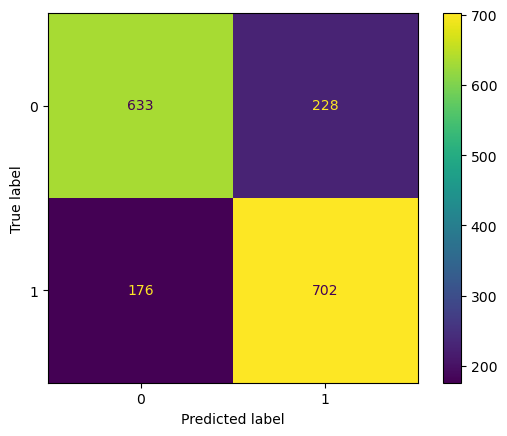

In [1315]:
def plot_matrix(model, y_test, y_pred):
    log_cm = confusion_matrix(y_test, y_pred, labels=model.classes_)

    # Create display of confusion matrix
    log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=model.classes_)

    # Plot confusion matrix
    log_disp.plot()

    # Display plot
    plt.show()
    
plot_matrix(clf_log, y_val, y_pred_log)

In [1316]:
preds = clf_log.predict(X_val)

auc = round(roc_auc_score(y_val, preds), 3)
accuracy = round(accuracy_score(y_val, preds), 3)
precision = round(precision_score(y_val, preds), 3)
recall = round(recall_score(y_val, preds), 3)
f1 = round(f1_score(y_val, preds), 3)

log_reg_table = pd.DataFrame({'model': "Logistic regression",
                    'AUC': [auc],
                    'precision': [precision], 
                    'recall': [recall],
                    'f1': [f1],
                    'accuracy': [accuracy]
                    })
log_reg_table  

,model,AUC,precision,recall,f1,accuracy
0,Logistic regression,0.767,0.755,0.8,0.777,0.768


### Random Forest Classifier

In [1317]:
clf_rf = RandomForestClassifier(random_state=42)

In [1318]:
cv_params = {'max_depth': [3, 5, None], 
             'max_features': [5, 8, 10, 20],
             'max_samples': [0.2, 0.3, 0.5, 0.7],
             'min_samples_leaf': [ 3, 5, 8],
             'min_samples_split': [2,],
             'n_estimators': [100, 200, 300, 400],
             }  

scoring = {'accuracy', 'precision', 'recall', 'f1'}

In [1319]:
def make_results(model_name: str, model_object, metric: str):
    '''
    Arguments:
        model_name (string): What you want the model to be called in the output table.
        model_object: A fit GridSearchCV object.
        metric (string): Precision, recall, f1, accuracy, or auc.
  
    Returns a pandas DataFrame with the F1, recall, precision, accuracy, and AUC scores
    for the model with the best mean 'metric' score across all validation folds.  
    '''

    # Create dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {
        'precision': 'mean_test_precision',
        'recall': 'mean_test_recall',
        'f1': 'mean_test_f1',
        'accuracy': 'mean_test_accuracy'
    }

    # Get all the results from the CV and put them in a DataFrame
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the DataFrame with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # Extract accuracy, precision, recall, and F1 score from that row
    f1 = best_estimator_results['mean_test_f1']
    recall = best_estimator_results['mean_test_recall']
    precision = best_estimator_results['mean_test_precision']
    accuracy = best_estimator_results['mean_test_accuracy']
  
    # Create DataFrame of results
    table = pd.DataFrame({
        'Model': [model_name],
        'Precision': precision,
        'Recall': recall,
        'F1': f1,
        'Accuracy': accuracy
    })
  
    return table

In [1320]:
def get_scores(model_name:str, model, X_test_data, y_test_data):
    '''
    Generate a table of test scores.

    In: 
        model_name (string):  How you want your model to be named in the output table
        model:                A fit GridSearchCV object
        X_test_data:          numpy array of X_test data
        y_test_data:          numpy array of y_test data

    Out: pandas df of precision, recall, f1, accuracy, and AUC scores for your model
    '''

    preds = model.best_estimator_.predict(X_test_data)

    auc = round(roc_auc_score(y_test_data, preds), 3)
    accuracy = round(accuracy_score(y_test_data, preds), 3)
    precision = round(precision_score(y_test_data, preds), 3)
    recall = round(recall_score(y_test_data, preds), 3)
    f1 = round(f1_score(y_test_data, preds), 3)

    table = pd.DataFrame({'model': [model_name],
                        'AUC': [auc],
                        'precision': [precision], 
                        'recall': [recall],
                        'f1': [f1],
                        'accuracy': [accuracy]
                        })
  
    return table

In [1321]:
%%time
rf_cv_acc = GridSearchCV(clf_rf, cv_params, scoring=scoring, cv=5, refit='accuracy')
rf_cv_acc.fit(X_train, y_train)

CPU times: user 24min 43s, sys: 13.7 s, total: 24min 56s
Wall time: 24min 57s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [3, 5, None],
                         'max_features': [5, 8, 10, 20],
                         'max_samples': [0.2, 0.3, 0.5, 0.7],
                         'min_samples_leaf': [3, 5, 8],
                         'min_samples_split': [2],
                         'n_estimators': [100, 200, 300, 400]},
             refit='accuracy',
             scoring={'precision', 'f1', 'recall', 'accuracy'})

In [1322]:
rf_cv_acc.best_score_

0.8088867281444434

In [1323]:
rf_cv_acc.best_params_

{'max_depth': None,
 'max_features': 5,
 'max_samples': 0.7,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 200}

In [1324]:
rf_table_acc = make_results("Random Forest Classifier accuracy", rf_cv_acc, "accuracy")
rf_table_acc

,Model,Precision,Recall,F1,Accuracy
0,Random Forest Classifier accuracy,0.806487,0.817143,0.811423,0.808887


In [1325]:
rf_score_acc = get_scores("Random Forest Classifier accuracy", rf_cv_acc, X_val, y_val)
rf_score_acc

,model,AUC,precision,recall,f1,accuracy
0,Random Forest Classifier accuracy,0.789,0.779,0.812,0.795,0.789


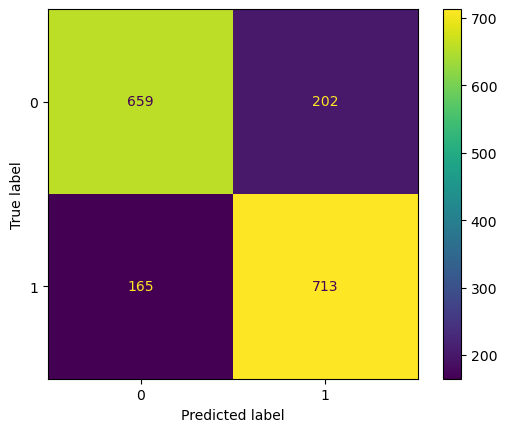

In [1326]:
plot_matrix(rf_cv_acc.best_estimator_, y_val, rf_cv_acc.best_estimator_.predict(X_val))

In [1327]:
model = rf_cv_acc.best_estimator_

In [1328]:
predictions = model.predict(df_test_corr)

In [1329]:
output = pd.DataFrame({'PassengerId': df_test.PassengerId, 'Transported': predictions})
output["Transported"] = output["Transported"].astype(bool)
output.to_csv('submission5.csv', index=False)

## Let's see our result's